<a href="https://colab.research.google.com/github/shankrsingh/classification/blob/master/distracted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')

In [0]:
import os
os.chdir('/gdrive/My Drive/distracted_drivers')

In [0]:
%pwd

'/gdrive/My Drive/distracted_drivers'

### Colab and Basic Preprocessing

In [0]:
user = 'shankarsingh'
key = '244ba8c2f5524f8431a8c43dbae0ab1a'

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c state-farm-distracted-driver-detection

In [0]:
!unzip s*

In [0]:
!unzip -q imgs.zip

In [0]:
!unzip sample_submi*

### Keras

In [0]:
import keras
from keras.utils import to_categorical,np_utils
from keras.preprocessing.image import img_to_array,load_img,ImageDataGenerator,array_to_img
from keras.models import Sequential,Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten,Input,BatchNormalization
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np
from keras.models import load_model
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [0]:
CLASSES = {"c0": "safe driving", "c1": "texting - right", "c2": "talking on the phone - right", "c3": "texting - left",
           "c4": "talking on the phone - left", "c5": "operating the radio", "c6": "drinking", "c7": "reaching behind",
           "c8": "hair and makeup", "c9": "talking to passenger"}

In [0]:
labels=pd.read_csv('driver_imgs_list.csv')

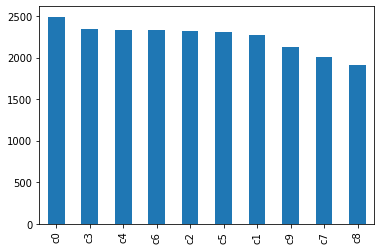

In [0]:
labels.classname.value_counts().plot(kind='bar')
plt.show()

In [0]:
labels.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [0]:
train_dir='train/'
test_dir='test/'


trainImgs = glob.glob(train_dir + '*/*.jpg')
testImgs=glob.glob(test_dir+'*.jpg')

print('Number of Images in train and test set',len(trainImgs),len(testImgs))

In [0]:
def show_drivers(cl='c0'):
  
  for i in range(1,5):
    plt.subplot(2,2,i)
    image_set=labels[labels['classname']==cl].img.iloc[i]
    im=train_dir +cl+'/'+ image_set
    im=load_img(im)
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])
  plt.suptitle(CLASSES[cl])
  plt.show()

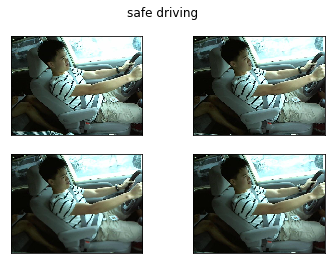

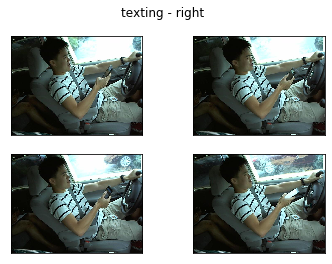

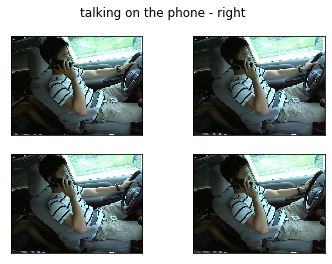

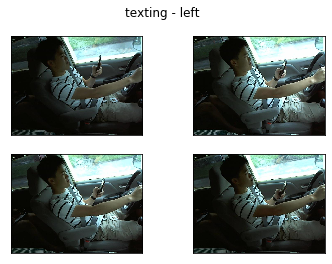

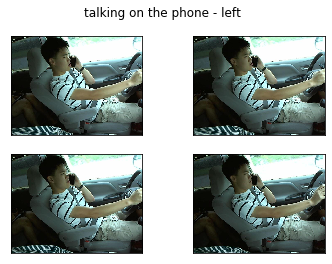

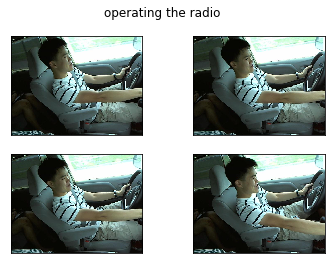

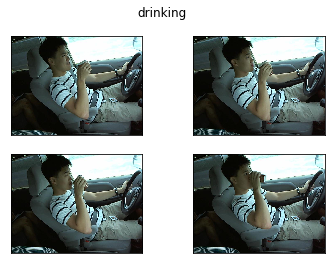

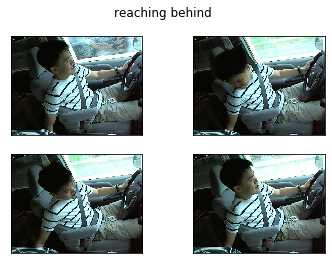

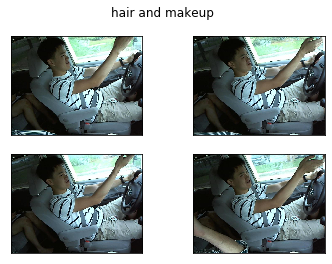

In [0]:
for i in range(9):
  clname='c'+str(i)
  show_drivers(clname)

In [0]:
BATCH_SIZE=64

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3,)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
test=ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        "train/",
        target_size=(128,128),
        batch_size=BATCH_SIZE,
        class_mode='categorical', subset="training", color_mode='grayscale')

val_generator = val_datagen.flow_from_directory(
        "train/",
        target_size=(128,128),
        batch_size=BATCH_SIZE,
        class_mode='categorical', subset="validation",  color_mode='grayscale')

Found 15702 images belonging to 10 classes.
Found 6722 images belonging to 10 classes.


In [0]:
vgg1=Sequential()
vgg1.add(Conv2D(32,3,padding='same',activation='relu',input_shape=(128,128,1)))
vgg1.add(Conv2D(32,3,padding='same',activation='relu',input_shape=(64,64,3)))
vgg1.add(MaxPooling2D(2))
vgg1.add(Conv2D(64,3,padding='same',activation='relu',input_shape=(64,64,3)))
vgg1.add(Conv2D(64,3,padding='same',activation='relu',input_shape=(64,64,3)))
vgg1.add(MaxPooling2D(2))
vgg1.add(Conv2D(128,3,padding='same',activation='relu',input_shape=(64,64,3)))
vgg1.add(Conv2D(128,3,padding='same',activation='relu',input_shape=(64,64,3)))
vgg1.add(MaxPooling2D(2))
vgg1.add(Flatten())
vgg1.add(Dense(128,activation='relu'))
vgg1.add(Dense(10,activation='softmax'))

vgg1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
vgg1.summary()







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)

In [0]:
def train(model, filepath):

    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    n_train = 15702
    batch_size = 128
    n_valid = 6722
    history = model.fit_generator(train_generator,
                                  steps_per_epoch=n_train//batch_size,
                                  epochs=10,
                                  validation_data=val_generator,
                                  validation_steps=n_valid//batch_size, 
                                  callbacks=callbacks_list)
    # Plot
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    return model

Epoch 1/10
122/122 [==============================] - 2806s 23s/step - loss: 1.4688 - acc: 0.4742 - val_loss: 0.4573 - val_acc: 0.8663

Epoch 00001: val_acc improved from -inf to 0.86629, saving model to vgg1.h5
Epoch 2/10
122/122 [==============================] - 2617s 21s/step - loss: 0.2763 - acc: 0.9264 - val_loss: 0.1448 - val_acc: 0.9651

Epoch 00002: val_acc improved from 0.86629 to 0.96514, saving model to vgg1.h5
Epoch 3/10
122/122 [==============================] - 61s 496ms/step - loss: 0.1024 - acc: 0.9732 - val_loss: 0.0831 - val_acc: 0.9780

Epoch 00003: val_acc improved from 0.96514 to 0.97795, saving model to vgg1.h5
Epoch 4/10
122/122 [==============================] - 53s 437ms/step - loss: 0.0654 - acc: 0.9812 - val_loss: 0.0979 - val_acc: 0.9760

Epoch 00004: val_acc did not improve from 0.97795
Epoch 5/10
122/122 [==============================] - 58s 477ms/step - loss: 0.0447 - acc: 0.9876 - val_loss: 0.0489 - val_acc: 0.9859

Epoch 00005: val_acc improved from 0

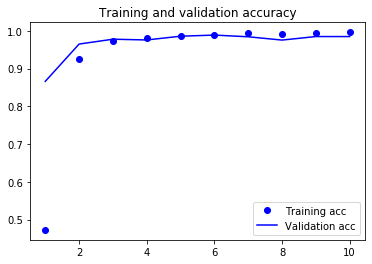

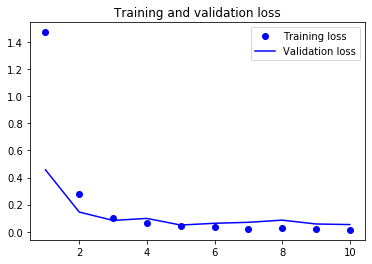

In [0]:
vgghist=train(vgg1,'vgg1.h5')

In [0]:
model = Sequential()
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (128,128, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.33))
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation = 'softmax')) 
model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])

model = train(model, "model_withBN.h5")









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 170 could not be retrieved. It could be because a worker has died.
  UserWarning)


  1/122 [..............................] - ETA: 1:38:32 - loss: 2.7904 - acc: 0.0938

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 198 could not be retrieved. It could be because a worker has died.
  UserWarning)


  2/122 [..............................] - ETA: 1:27:06 - loss: 3.0453 - acc: 0.1016

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 192 could not be retrieved. It could be because a worker has died.
  UserWarning)


  3/122 [..............................] - ETA: 1:18:47 - loss: 2.9279 - acc: 0.1146

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 197 could not be retrieved. It could be because a worker has died.
  UserWarning)


  4/122 [..............................] - ETA: 1:19:58 - loss: 2.8507 - acc: 0.1211

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 228 could not be retrieved. It could be because a worker has died.
  UserWarning)


  5/122 [>.............................] - ETA: 1:17:00 - loss: 2.7747 - acc: 0.1250

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 217 could not be retrieved. It could be because a worker has died.
  UserWarning)


  6/122 [>.............................] - ETA: 1:17:02 - loss: 2.7404 - acc: 0.1380

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 111 could not be retrieved. It could be because a worker has died.
  UserWarning)


  7/122 [>.............................] - ETA: 1:14:33 - loss: 2.7085 - acc: 0.1406

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 231 could not be retrieved. It could be because a worker has died.
  UserWarning)


  8/122 [>.............................] - ETA: 1:12:35 - loss: 2.6750 - acc: 0.1387

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 171 could not be retrieved. It could be because a worker has died.
  UserWarning)


  9/122 [=>............................] - ETA: 1:12:07 - loss: 2.6407 - acc: 0.1493

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 174 could not be retrieved. It could be because a worker has died.
  UserWarning)


 10/122 [=>............................] - ETA: 1:10:47 - loss: 2.6080 - acc: 0.1484

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 180 could not be retrieved. It could be because a worker has died.
  UserWarning)


 11/122 [=>............................] - ETA: 1:09:51 - loss: 2.5902 - acc: 0.1477

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 157 could not be retrieved. It could be because a worker has died.
  UserWarning)


 12/122 [=>............................] - ETA: 1:08:46 - loss: 2.5466 - acc: 0.1615

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 164 could not be retrieved. It could be because a worker has died.
  UserWarning)


 13/122 [==>...........................] - ETA: 1:07:17 - loss: 2.5159 - acc: 0.1719

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 16 could not be retrieved. It could be because a worker has died.
  UserWarning)


 14/122 [==>...........................] - ETA: 1:05:57 - loss: 2.5039 - acc: 0.1775

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 129 could not be retrieved. It could be because a worker has died.
  UserWarning)


 15/122 [==>...........................] - ETA: 1:05:09 - loss: 2.4661 - acc: 0.1885

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 69 could not be retrieved. It could be because a worker has died.
  UserWarning)


 16/122 [==>...........................] - ETA: 1:03:55 - loss: 2.4388 - acc: 0.1982

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 137 could not be retrieved. It could be because a worker has died.
  UserWarning)


 19/122 [===>..........................] - ETA: 1:00:31 - loss: 2.3892 - acc: 0.2072

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 145 could not be retrieved. It could be because a worker has died.
  UserWarning)


 20/122 [===>..........................] - ETA: 59:59 - loss: 2.3678 - acc: 0.2148  

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 63 could not be retrieved. It could be because a worker has died.
  UserWarning)


 21/122 [====>.........................] - ETA: 59:24 - loss: 2.3561 - acc: 0.2173

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 24 could not be retrieved. It could be because a worker has died.
  UserWarning)


 22/122 [====>.........................] - ETA: 58:28 - loss: 2.3303 - acc: 0.2259

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 224 could not be retrieved. It could be because a worker has died.
  UserWarning)


 24/122 [====>.........................] - ETA: 57:04 - loss: 2.2887 - acc: 0.2357

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 133 could not be retrieved. It could be because a worker has died.
  UserWarning)


 25/122 [=====>........................] - ETA: 57:07 - loss: 2.2645 - acc: 0.2406

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 120 could not be retrieved. It could be because a worker has died.
  UserWarning)


 28/122 [=====>........................] - ETA: 54:47 - loss: 2.2206 - acc: 0.2494

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 6 could not be retrieved. It could be because a worker has died.
  UserWarning)


 29/122 [======>.......................] - ETA: 54:00 - loss: 2.2053 - acc: 0.2538

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 240 could not be retrieved. It could be because a worker has died.
  UserWarning)


 30/122 [======>.......................] - ETA: 53:16 - loss: 2.1807 - acc: 0.2620

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 81 could not be retrieved. It could be because a worker has died.
  UserWarning)


 31/122 [======>.......................] - ETA: 52:29 - loss: 2.1672 - acc: 0.2671

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 40 could not be retrieved. It could be because a worker has died.
  UserWarning)


 32/122 [======>.......................] - ETA: 52:00 - loss: 2.1510 - acc: 0.2734

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 86 could not be retrieved. It could be because a worker has died.
  UserWarning)


 33/122 [=======>......................] - ETA: 51:17 - loss: 2.1321 - acc: 0.2789

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 191 could not be retrieved. It could be because a worker has died.
  UserWarning)


 34/122 [=======>......................] - ETA: 50:41 - loss: 2.1099 - acc: 0.2877

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 143 could not be retrieved. It could be because a worker has died.
  UserWarning)


 35/122 [=======>......................] - ETA: 50:04 - loss: 2.0944 - acc: 0.2946

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


 36/122 [=======>......................] - ETA: 49:25 - loss: 2.0792 - acc: 0.3012

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 112 could not be retrieved. It could be because a worker has died.
  UserWarning)


 37/122 [========>.....................] - ETA: 48:41 - loss: 2.0703 - acc: 0.3036

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 161 could not be retrieved. It could be because a worker has died.
  UserWarning)


 38/122 [========>.....................] - ETA: 48:00 - loss: 2.0550 - acc: 0.3088

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 25 could not be retrieved. It could be because a worker has died.
  UserWarning)


 39/122 [========>.....................] - ETA: 47:21 - loss: 2.0447 - acc: 0.3141

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 216 could not be retrieved. It could be because a worker has died.
  UserWarning)


 40/122 [========>.....................] - ETA: 46:41 - loss: 2.0264 - acc: 0.3203

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 190 could not be retrieved. It could be because a worker has died.
  UserWarning)


 41/122 [=========>....................] - ETA: 46:06 - loss: 2.0099 - acc: 0.3274

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 42 could not be retrieved. It could be because a worker has died.
  UserWarning)


 42/122 [=========>....................] - ETA: 45:27 - loss: 1.9997 - acc: 0.3311

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 219 could not be retrieved. It could be because a worker has died.
  UserWarning)


 43/122 [=========>....................] - ETA: 44:50 - loss: 1.9863 - acc: 0.3350

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 52 could not be retrieved. It could be because a worker has died.
  UserWarning)


 45/122 [==========>...................] - ETA: 43:44 - loss: 1.9549 - acc: 0.3469

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 22 could not be retrieved. It could be because a worker has died.
  UserWarning)


 46/122 [==========>...................] - ETA: 43:06 - loss: 1.9389 - acc: 0.3539

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 77 could not be retrieved. It could be because a worker has died.
  UserWarning)


 47/122 [==========>...................] - ETA: 42:38 - loss: 1.9259 - acc: 0.3574

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 127 could not be retrieved. It could be because a worker has died.
  UserWarning)


 48/122 [==========>...................] - ETA: 42:08 - loss: 1.9102 - acc: 0.3636

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 15 could not be retrieved. It could be because a worker has died.
  UserWarning)


 49/122 [===========>..................] - ETA: 41:37 - loss: 1.8972 - acc: 0.3683

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 14 could not be retrieved. It could be because a worker has died.
  UserWarning)


 50/122 [===========>..................] - ETA: 41:01 - loss: 1.8828 - acc: 0.3738

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 222 could not be retrieved. It could be because a worker has died.
  UserWarning)


 51/122 [===========>..................] - ETA: 40:25 - loss: 1.8718 - acc: 0.3775

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 211 could not be retrieved. It could be because a worker has died.
  UserWarning)


 52/122 [===========>..................] - ETA: 39:51 - loss: 1.8618 - acc: 0.3801

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 32 could not be retrieved. It could be because a worker has died.
  UserWarning)


 53/122 [============>.................] - ETA: 39:13 - loss: 1.8482 - acc: 0.3859

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 31 could not be retrieved. It could be because a worker has died.
  UserWarning)


 54/122 [============>.................] - ETA: 38:34 - loss: 1.8367 - acc: 0.3918

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 212 could not be retrieved. It could be because a worker has died.
  UserWarning)


 56/122 [============>.................] - ETA: 37:27 - loss: 1.8104 - acc: 0.4021

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 223 could not be retrieved. It could be because a worker has died.
  UserWarning)


 57/122 [=============>................] - ETA: 36:51 - loss: 1.7962 - acc: 0.4079

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 134 could not be retrieved. It could be because a worker has died.
  UserWarning)


 58/122 [=============>................] - ETA: 36:20 - loss: 1.7870 - acc: 0.4106

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 83 could not be retrieved. It could be because a worker has died.
  UserWarning)


 59/122 [=============>................] - ETA: 35:47 - loss: 1.7776 - acc: 0.4142

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 208 could not be retrieved. It could be because a worker has died.
  UserWarning)


 60/122 [=============>................] - ETA: 35:12 - loss: 1.7656 - acc: 0.4185

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 122 could not be retrieved. It could be because a worker has died.
  UserWarning)


 61/122 [==============>...............] - ETA: 34:36 - loss: 1.7550 - acc: 0.4221

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 92 could not be retrieved. It could be because a worker has died.
  UserWarning)


 62/122 [==============>...............] - ETA: 34:06 - loss: 1.7459 - acc: 0.4259

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 232 could not be retrieved. It could be because a worker has died.
  UserWarning)


 64/122 [==============>...............] - ETA: 32:55 - loss: 1.7260 - acc: 0.4353

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 50 could not be retrieved. It could be because a worker has died.
  UserWarning)


 65/122 [==============>...............] - ETA: 32:32 - loss: 1.7140 - acc: 0.4401

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 36 could not be retrieved. It could be because a worker has died.
  UserWarning)


 67/122 [===============>..............] - ETA: 31:19 - loss: 1.6962 - acc: 0.4457

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 165 could not be retrieved. It could be because a worker has died.
  UserWarning)


 68/122 [===============>..............] - ETA: 30:42 - loss: 1.6867 - acc: 0.4488

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 226 could not be retrieved. It could be because a worker has died.
  UserWarning)


 69/122 [===============>..............] - ETA: 30:05 - loss: 1.6769 - acc: 0.4529

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 51 could not be retrieved. It could be because a worker has died.
  UserWarning)


 73/122 [================>.............] - ETA: 27:40 - loss: 1.6380 - acc: 0.4696

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 159 could not be retrieved. It could be because a worker has died.
  UserWarning)


 74/122 [=================>............] - ETA: 27:08 - loss: 1.6282 - acc: 0.4738

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 124 could not be retrieved. It could be because a worker has died.
  UserWarning)


 76/122 [=================>............] - ETA: 26:01 - loss: 1.6098 - acc: 0.4807

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 186 could not be retrieved. It could be because a worker has died.
  UserWarning)


 77/122 [=================>............] - ETA: 25:25 - loss: 1.6001 - acc: 0.4848

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 28 could not be retrieved. It could be because a worker has died.
  UserWarning)


 78/122 [==================>...........] - ETA: 24:52 - loss: 1.5912 - acc: 0.4878

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 68 could not be retrieved. It could be because a worker has died.
  UserWarning)


 79/122 [==================>...........] - ETA: 24:20 - loss: 1.5821 - acc: 0.4919

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 41 could not be retrieved. It could be because a worker has died.
  UserWarning)


 80/122 [==================>...........] - ETA: 23:44 - loss: 1.5731 - acc: 0.4963

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 221 could not be retrieved. It could be because a worker has died.
  UserWarning)


 81/122 [==================>...........] - ETA: 23:09 - loss: 1.5620 - acc: 0.5014

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 76 could not be retrieved. It could be because a worker has died.
  UserWarning)


 82/122 [===================>..........] - ETA: 22:35 - loss: 1.5511 - acc: 0.5061

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


 83/122 [===================>..........] - ETA: 21:59 - loss: 1.5412 - acc: 0.5098

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 162 could not be retrieved. It could be because a worker has died.
  UserWarning)


 84/122 [===================>..........] - ETA: 21:26 - loss: 1.5328 - acc: 0.5128

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 37 could not be retrieved. It could be because a worker has died.
  UserWarning)


 85/122 [===================>..........] - ETA: 20:55 - loss: 1.5233 - acc: 0.5165

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 205 could not be retrieved. It could be because a worker has died.
  UserWarning)


 86/122 [====================>.........] - ETA: 20:23 - loss: 1.5148 - acc: 0.5193

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 181 could not be retrieved. It could be because a worker has died.
  UserWarning)


 87/122 [====================>.........] - ETA: 19:50 - loss: 1.5049 - acc: 0.5230

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 8 could not be retrieved. It could be because a worker has died.
  UserWarning)


 88/122 [====================>.........] - ETA: 19:19 - loss: 1.4964 - acc: 0.5261

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 58 could not be retrieved. It could be because a worker has died.
  UserWarning)


 89/122 [====================>.........] - ETA: 18:48 - loss: 1.4882 - acc: 0.5283

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 218 could not be retrieved. It could be because a worker has died.
  UserWarning)


 90/122 [=====================>........] - ETA: 18:13 - loss: 1.4784 - acc: 0.5319

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 99 could not be retrieved. It could be because a worker has died.
  UserWarning)


 91/122 [=====================>........] - ETA: 17:41 - loss: 1.4722 - acc: 0.5342

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 239 could not be retrieved. It could be because a worker has died.
  UserWarning)


 92/122 [=====================>........] - ETA: 17:10 - loss: 1.4631 - acc: 0.5379

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)


 93/122 [=====================>........] - ETA: 16:38 - loss: 1.4559 - acc: 0.5407

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 114 could not be retrieved. It could be because a worker has died.
  UserWarning)


 94/122 [======================>.......] - ETA: 16:04 - loss: 1.4483 - acc: 0.5436

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 84 could not be retrieved. It could be because a worker has died.
  UserWarning)


 95/122 [======================>.......] - ETA: 15:32 - loss: 1.4414 - acc: 0.5462

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 71 could not be retrieved. It could be because a worker has died.
  UserWarning)


 96/122 [======================>.......] - ETA: 14:59 - loss: 1.4334 - acc: 0.5492

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 214 could not be retrieved. It could be because a worker has died.
  UserWarning)


 97/122 [======================>.......] - ETA: 14:26 - loss: 1.4251 - acc: 0.5524

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 27 could not be retrieved. It could be because a worker has died.
  UserWarning)


 98/122 [=======================>......] - ETA: 13:51 - loss: 1.4171 - acc: 0.5558

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 53 could not be retrieved. It could be because a worker has died.
  UserWarning)


 99/122 [=======================>......] - ETA: 13:19 - loss: 1.4111 - acc: 0.5576

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 203 could not be retrieved. It could be because a worker has died.
  UserWarning)


100/122 [=======================>......] - ETA: 12:44 - loss: 1.4032 - acc: 0.5611

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 54 could not be retrieved. It could be because a worker has died.
  UserWarning)


101/122 [=======================>......] - ETA: 12:08 - loss: 1.3953 - acc: 0.5645

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 95 could not be retrieved. It could be because a worker has died.
  UserWarning)


102/122 [========================>.....] - ETA: 11:33 - loss: 1.3876 - acc: 0.5679

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 175 could not be retrieved. It could be because a worker has died.
  UserWarning)


103/122 [========================>.....] - ETA: 10:58 - loss: 1.3792 - acc: 0.5711

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 49 could not be retrieved. It could be because a worker has died.
  UserWarning)


105/122 [========================>.....] - ETA: 9:48 - loss: 1.3638 - acc: 0.5769 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 220 could not be retrieved. It could be because a worker has died.
  UserWarning)


106/122 [=========================>....] - ETA: 9:14 - loss: 1.3556 - acc: 0.5797

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 121 could not be retrieved. It could be because a worker has died.
  UserWarning)


107/122 [=========================>....] - ETA: 8:38 - loss: 1.3488 - acc: 0.5821

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 199 could not be retrieved. It could be because a worker has died.
  UserWarning)


108/122 [=========================>....] - ETA: 8:04 - loss: 1.3414 - acc: 0.5848

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 117 could not be retrieved. It could be because a worker has died.
  UserWarning)


110/122 [==========================>...] - ETA: 6:55 - loss: 1.3290 - acc: 0.5893

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 104 could not be retrieved. It could be because a worker has died.
  UserWarning)


111/122 [==========================>...] - ETA: 6:20 - loss: 1.3208 - acc: 0.5928

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 43 could not be retrieved. It could be because a worker has died.
  UserWarning)


112/122 [==========================>...] - ETA: 5:46 - loss: 1.3153 - acc: 0.5947

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 183 could not be retrieved. It could be because a worker has died.
  UserWarning)


113/122 [==========================>...] - ETA: 5:11 - loss: 1.3080 - acc: 0.5975

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 106 could not be retrieved. It could be because a worker has died.
  UserWarning)


114/122 [===========================>..] - ETA: 4:36 - loss: 1.3009 - acc: 0.6002

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)


115/122 [===========================>..] - ETA: 4:02 - loss: 1.2941 - acc: 0.6027

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 241 could not be retrieved. It could be because a worker has died.
  UserWarning)


116/122 [===========================>..] - ETA: 3:27 - loss: 1.2873 - acc: 0.6055

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 34 could not be retrieved. It could be because a worker has died.
  UserWarning)


117/122 [===========================>..] - ETA: 2:52 - loss: 1.2809 - acc: 0.6080

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 194 could not be retrieved. It could be because a worker has died.
  UserWarning)


118/122 [============================>.] - ETA: 2:18 - loss: 1.2739 - acc: 0.6104

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 215 could not be retrieved. It could be because a worker has died.
  UserWarning)


119/122 [============================>.] - ETA: 1:43 - loss: 1.2677 - acc: 0.6124

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 242 could not be retrieved. It could be because a worker has died.
  UserWarning)


120/122 [============================>.] - ETA: 1:09 - loss: 1.2621 - acc: 0.6142

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 184 could not be retrieved. It could be because a worker has died.
  UserWarning)


121/122 [============================>.] - ETA: 34s - loss: 1.2570 - acc: 0.6163 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 195 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 11 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 12 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 17 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 18 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 19 could not be retrieved. It could 

122/122 [==============================] - 5715s 47s/step - loss: 1.2511 - acc: 0.6185 - val_loss: 0.3924 - val_acc: 0.9117

Epoch 00001: val_acc improved from -inf to 0.91166, saving model to model_withBN.h5
Epoch 2/10
 12/122 [=>............................] - ETA: 6:00 - loss: 0.5221 - acc: 0.8789

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 118 could not be retrieved. It could be because a worker has died.
  UserWarning)


 13/122 [==>...........................] - ETA: 11:17 - loss: 0.5202 - acc: 0.8822

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


 15/122 [==>...........................] - ETA: 15:14 - loss: 0.5233 - acc: 0.8827

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 82 could not be retrieved. It could be because a worker has died.
  UserWarning)


 16/122 [==>...........................] - ETA: 18:23 - loss: 0.5183 - acc: 0.8841

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 237 could not be retrieved. It could be because a worker has died.
  UserWarning)


 17/122 [===>..........................] - ETA: 21:00 - loss: 0.5116 - acc: 0.8864

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 55 could not be retrieved. It could be because a worker has died.
  UserWarning)


 18/122 [===>..........................] - ETA: 22:52 - loss: 0.5127 - acc: 0.8857

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 158 could not be retrieved. It could be because a worker has died.
  UserWarning)


 19/122 [===>..........................] - ETA: 25:04 - loss: 0.5139 - acc: 0.8827

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 85 could not be retrieved. It could be because a worker has died.
  UserWarning)


 21/122 [====>.........................] - ETA: 28:37 - loss: 0.5129 - acc: 0.8857

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 30 could not be retrieved. It could be because a worker has died.
  UserWarning)


 22/122 [====>.........................] - ETA: 29:43 - loss: 0.5100 - acc: 0.8866

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 173 could not be retrieved. It could be because a worker has died.
  UserWarning)


 23/122 [====>.........................] - ETA: 30:25 - loss: 0.5109 - acc: 0.8882

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 206 could not be retrieved. It could be because a worker has died.
  UserWarning)


 24/122 [====>.........................] - ETA: 31:13 - loss: 0.5138 - acc: 0.8857

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 67 could not be retrieved. It could be because a worker has died.
  UserWarning)


 25/122 [=====>........................] - ETA: 32:38 - loss: 0.5141 - acc: 0.8846

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 229 could not be retrieved. It could be because a worker has died.
  UserWarning)


 26/122 [=====>........................] - ETA: 33:51 - loss: 0.5102 - acc: 0.8872

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 88 could not be retrieved. It could be because a worker has died.
  UserWarning)


 27/122 [=====>........................] - ETA: 34:19 - loss: 0.5057 - acc: 0.8885

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 172 could not be retrieved. It could be because a worker has died.
  UserWarning)


 28/122 [=====>........................] - ETA: 34:54 - loss: 0.4985 - acc: 0.8908

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 155 could not be retrieved. It could be because a worker has died.
  UserWarning)


 29/122 [======>.......................] - ETA: 35:15 - loss: 0.4992 - acc: 0.8892

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 56 could not be retrieved. It could be because a worker has died.
  UserWarning)


 30/122 [======>.......................] - ETA: 35:25 - loss: 0.4938 - acc: 0.8913

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


 31/122 [======>.......................] - ETA: 35:46 - loss: 0.4962 - acc: 0.8898

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 29 could not be retrieved. It could be because a worker has died.
  UserWarning)


 32/122 [======>.......................] - ETA: 36:11 - loss: 0.4936 - acc: 0.8913

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 126 could not be retrieved. It could be because a worker has died.
  UserWarning)


 33/122 [=======>......................] - ETA: 36:24 - loss: 0.4910 - acc: 0.8922

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 169 could not be retrieved. It could be because a worker has died.
  UserWarning)


 34/122 [=======>......................] - ETA: 36:22 - loss: 0.4878 - acc: 0.8931

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 101 could not be retrieved. It could be because a worker has died.
  UserWarning)


 35/122 [=======>......................] - ETA: 36:20 - loss: 0.4850 - acc: 0.8944

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 202 could not be retrieved. It could be because a worker has died.
  UserWarning)


 36/122 [=======>......................] - ETA: 36:37 - loss: 0.4809 - acc: 0.8960

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 60 could not be retrieved. It could be because a worker has died.
  UserWarning)


 37/122 [========>.....................] - ETA: 36:42 - loss: 0.4785 - acc: 0.8967

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 189 could not be retrieved. It could be because a worker has died.
  UserWarning)


 38/122 [========>.....................] - ETA: 36:35 - loss: 0.4769 - acc: 0.8969

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 163 could not be retrieved. It could be because a worker has died.
  UserWarning)


 39/122 [========>.....................] - ETA: 36:24 - loss: 0.4754 - acc: 0.8964

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 225 could not be retrieved. It could be because a worker has died.
  UserWarning)


 40/122 [========>.....................] - ETA: 36:37 - loss: 0.4737 - acc: 0.8970

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 89 could not be retrieved. It could be because a worker has died.
  UserWarning)


 41/122 [=========>....................] - ETA: 36:33 - loss: 0.4743 - acc: 0.8961

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 210 could not be retrieved. It could be because a worker has died.
  UserWarning)


 42/122 [=========>....................] - ETA: 36:23 - loss: 0.4710 - acc: 0.8963

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 149 could not be retrieved. It could be because a worker has died.
  UserWarning)


 44/122 [=========>....................] - ETA: 36:33 - loss: 0.4670 - acc: 0.8964

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 125 could not be retrieved. It could be because a worker has died.
  UserWarning)


 45/122 [==========>...................] - ETA: 36:10 - loss: 0.4645 - acc: 0.8973

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 233 could not be retrieved. It could be because a worker has died.
  UserWarning)


 46/122 [==========>...................] - ETA: 35:50 - loss: 0.4637 - acc: 0.8969

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 168 could not be retrieved. It could be because a worker has died.
  UserWarning)


 48/122 [==========>...................] - ETA: 35:10 - loss: 0.4566 - acc: 0.8989

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 72 could not be retrieved. It could be because a worker has died.
  UserWarning)


 51/122 [===========>..................] - ETA: 34:15 - loss: 0.4487 - acc: 0.9005

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 160 could not be retrieved. It could be because a worker has died.
  UserWarning)


 52/122 [===========>..................] - ETA: 34:04 - loss: 0.4457 - acc: 0.9022

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 98 could not be retrieved. It could be because a worker has died.
  UserWarning)


 53/122 [============>.................] - ETA: 33:50 - loss: 0.4437 - acc: 0.9028

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 187 could not be retrieved. It could be because a worker has died.
  UserWarning)


 55/122 [============>.................] - ETA: 33:03 - loss: 0.4407 - acc: 0.9035

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 103 could not be retrieved. It could be because a worker has died.
  UserWarning)


 56/122 [============>.................] - ETA: 32:35 - loss: 0.4410 - acc: 0.9030

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 213 could not be retrieved. It could be because a worker has died.
  UserWarning)


 57/122 [=============>................] - ETA: 32:07 - loss: 0.4419 - acc: 0.9025

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 10 could not be retrieved. It could be because a worker has died.
  UserWarning)


 58/122 [=============>................] - ETA: 31:40 - loss: 0.4399 - acc: 0.9034

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 115 could not be retrieved. It could be because a worker has died.
  UserWarning)


 59/122 [=============>................] - ETA: 31:16 - loss: 0.4374 - acc: 0.9042

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 9 could not be retrieved. It could be because a worker has died.
  UserWarning)


 60/122 [=============>................] - ETA: 30:57 - loss: 0.4334 - acc: 0.9056

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 140 could not be retrieved. It could be because a worker has died.
  UserWarning)


 61/122 [==============>...............] - ETA: 30:32 - loss: 0.4315 - acc: 0.9061

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 116 could not be retrieved. It could be because a worker has died.
  UserWarning)


 62/122 [==============>...............] - ETA: 30:15 - loss: 0.4282 - acc: 0.9071

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


 63/122 [==============>...............] - ETA: 29:50 - loss: 0.4271 - acc: 0.9068

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 96 could not be retrieved. It could be because a worker has died.
  UserWarning)


 64/122 [==============>...............] - ETA: 29:29 - loss: 0.4260 - acc: 0.9076

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 188 could not be retrieved. It could be because a worker has died.
  UserWarning)


 65/122 [==============>...............] - ETA: 29:03 - loss: 0.4236 - acc: 0.9083

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 235 could not be retrieved. It could be because a worker has died.
  UserWarning)


 66/122 [===============>..............] - ETA: 28:39 - loss: 0.4233 - acc: 0.9082

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 79 could not be retrieved. It could be because a worker has died.
  UserWarning)


 67/122 [===============>..............] - ETA: 28:13 - loss: 0.4225 - acc: 0.9087

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 200 could not be retrieved. It could be because a worker has died.
  UserWarning)


 68/122 [===============>..............] - ETA: 27:47 - loss: 0.4191 - acc: 0.9098

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 93 could not be retrieved. It could be because a worker has died.
  UserWarning)


 69/122 [===============>..............] - ETA: 27:16 - loss: 0.4195 - acc: 0.9095

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 90 could not be retrieved. It could be because a worker has died.
  UserWarning)


 72/122 [================>.............] - ETA: 25:45 - loss: 0.4133 - acc: 0.9115

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 132 could not be retrieved. It could be because a worker has died.
  UserWarning)


 73/122 [================>.............] - ETA: 25:17 - loss: 0.4139 - acc: 0.9117

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 238 could not be retrieved. It could be because a worker has died.
  UserWarning)


 74/122 [=================>............] - ETA: 24:53 - loss: 0.4131 - acc: 0.9116

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 65 could not be retrieved. It could be because a worker has died.
  UserWarning)


 75/122 [=================>............] - ETA: 24:23 - loss: 0.4110 - acc: 0.9124

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 244 could not be retrieved. It could be because a worker has died.
  UserWarning)


 76/122 [=================>............] - ETA: 24:01 - loss: 0.4098 - acc: 0.9125

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 166 could not be retrieved. It could be because a worker has died.
  UserWarning)


 77/122 [=================>............] - ETA: 23:32 - loss: 0.4078 - acc: 0.9132

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 176 could not be retrieved. It could be because a worker has died.
  UserWarning)


 79/122 [==================>...........] - ETA: 22:29 - loss: 0.4053 - acc: 0.9136

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 151 could not be retrieved. It could be because a worker has died.
  UserWarning)


 80/122 [==================>...........] - ETA: 22:05 - loss: 0.4048 - acc: 0.9141

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 150 could not be retrieved. It could be because a worker has died.
  UserWarning)


 82/122 [===================>..........] - ETA: 21:03 - loss: 0.4005 - acc: 0.9155

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 209 could not be retrieved. It could be because a worker has died.
  UserWarning)


 83/122 [===================>..........] - ETA: 20:34 - loss: 0.3991 - acc: 0.9161

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 243 could not be retrieved. It could be because a worker has died.
  UserWarning)


 84/122 [===================>..........] - ETA: 20:03 - loss: 0.3976 - acc: 0.9167

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 154 could not be retrieved. It could be because a worker has died.
  UserWarning)


 85/122 [===================>..........] - ETA: 19:34 - loss: 0.3957 - acc: 0.9173

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 123 could not be retrieved. It could be because a worker has died.
  UserWarning)


 86/122 [====================>.........] - ETA: 19:02 - loss: 0.3942 - acc: 0.9181

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 87 could not be retrieved. It could be because a worker has died.
  UserWarning)


 87/122 [====================>.........] - ETA: 18:32 - loss: 0.3917 - acc: 0.9189

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 177 could not be retrieved. It could be because a worker has died.
  UserWarning)


 89/122 [====================>.........] - ETA: 17:34 - loss: 0.3875 - acc: 0.9202

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 57 could not be retrieved. It could be because a worker has died.
  UserWarning)


 91/122 [=====================>........] - ETA: 16:33 - loss: 0.3859 - acc: 0.9202

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 142 could not be retrieved. It could be because a worker has died.
  UserWarning)


 92/122 [=====================>........] - ETA: 16:01 - loss: 0.3842 - acc: 0.9204

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 113 could not be retrieved. It could be because a worker has died.
  UserWarning)


 94/122 [======================>.......] - ETA: 15:07 - loss: 0.3815 - acc: 0.9208

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 100 could not be retrieved. It could be because a worker has died.
  UserWarning)


 95/122 [======================>.......] - ETA: 14:34 - loss: 0.3792 - acc: 0.9214

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 135 could not be retrieved. It could be because a worker has died.
  UserWarning)


 96/122 [======================>.......] - ETA: 14:05 - loss: 0.3771 - acc: 0.9221

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 78 could not be retrieved. It could be because a worker has died.
  UserWarning)


 98/122 [=======================>......] - ETA: 13:04 - loss: 0.3746 - acc: 0.9229

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 61 could not be retrieved. It could be because a worker has died.
  UserWarning)


 99/122 [=======================>......] - ETA: 12:32 - loss: 0.3731 - acc: 0.9234

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 144 could not be retrieved. It could be because a worker has died.
  UserWarning)


100/122 [=======================>......] - ETA: 12:00 - loss: 0.3718 - acc: 0.9235

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 152 could not be retrieved. It could be because a worker has died.
  UserWarning)


102/122 [========================>.....] - ETA: 10:56 - loss: 0.3690 - acc: 0.9242

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 48 could not be retrieved. It could be because a worker has died.
  UserWarning)


103/122 [========================>.....] - ETA: 10:23 - loss: 0.3673 - acc: 0.9250

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 201 could not be retrieved. It could be because a worker has died.
  UserWarning)


104/122 [========================>.....] - ETA: 9:51 - loss: 0.3655 - acc: 0.9255 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 91 could not be retrieved. It could be because a worker has died.
  UserWarning)


105/122 [========================>.....] - ETA: 9:18 - loss: 0.3638 - acc: 0.9261

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 185 could not be retrieved. It could be because a worker has died.
  UserWarning)


106/122 [=========================>....] - ETA: 8:45 - loss: 0.3626 - acc: 0.9265

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 74 could not be retrieved. It could be because a worker has died.
  UserWarning)


107/122 [=========================>....] - ETA: 8:13 - loss: 0.3614 - acc: 0.9269

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 227 could not be retrieved. It could be because a worker has died.
  UserWarning)


108/122 [=========================>....] - ETA: 7:40 - loss: 0.3604 - acc: 0.9268

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 97 could not be retrieved. It could be because a worker has died.
  UserWarning)


111/122 [==========================>...] - ETA: 6:02 - loss: 0.3569 - acc: 0.9270

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 64 could not be retrieved. It could be because a worker has died.
  UserWarning)


113/122 [==========================>...] - ETA: 4:56 - loss: 0.3544 - acc: 0.9277

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 66 could not be retrieved. It could be because a worker has died.
  UserWarning)


114/122 [===========================>..] - ETA: 4:24 - loss: 0.3540 - acc: 0.9280

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 130 could not be retrieved. It could be because a worker has died.
  UserWarning)


116/122 [===========================>..] - ETA: 3:18 - loss: 0.3529 - acc: 0.9279

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 107 could not be retrieved. It could be because a worker has died.
  UserWarning)


118/122 [============================>.] - ETA: 2:12 - loss: 0.3501 - acc: 0.9284

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 148 could not be retrieved. It could be because a worker has died.
  UserWarning)


121/122 [============================>.] - ETA: 32s - loss: 0.3462 - acc: 0.9293 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 204 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 70 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 73 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 75 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 80 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 94 could not be retrieved. It could 

122/122 [==============================] - 5472s 45s/step - loss: 0.3453 - acc: 0.9294 - val_loss: 0.3482 - val_acc: 0.9078

Epoch 00002: val_acc did not improve from 0.91166
Epoch 3/10
  2/122 [..............................] - ETA: 14s - loss: 0.2038 - acc: 0.9766

In [0]:
model=load_model('model_withBN.h5')

In [0]:
model=load_model('vgg1.h5')

In [0]:
model.evaluate_generator(val_generator,steps=val_generator.samples/128)